# Optimisation of the Global Calculator via Genetic Algorithms

This investigation aims to generate different climate change mitigation pathways with the “Global Calculator” - a complex model used to forecast the world’s energy, food and land systems to 2050 (http://tool.globalcalculator.org/). Performing a constrained optimisation of the model’s input parameter space yields alternative pathways to sustainability. 
 
The key challenge of such an optimisation is to explore a broad parameter space (~9e50 different parameter combinations) rapidly.

Genetic algorithms are commonly used to generate solutions to optimisation problems by using biologically inspired operators such as mutation, crossover and selection.

In this implementation, each generation contains a fixed number of chromosomes (lever combinations). The two fittest (measured by the cost function) chromosomes are selected. These two are mated, yielding a new generation. In this process, random mutations are introduced - These correspond to randomly moving a lever up or down by a quantity of 0.1. 

This implementation enables the user to find a lever combination that is closest to meeting the constraints. Such constraints are divided into four types:

- Input value constraints: The value of any input can be fixed. For example, as per our discussion, we can fix Electric & Hydrogen to 3.0, Global Population to 2.0, Wind to 2.5, Nuclear to 1.0 and Solar Capacity to 3.2. 
- Input range constraints: I have bounded the range of each lever between 1.5 and 3.5 to avoid extreme / non-realistic values. The range of each lever can be specified – For example, I have (arbitrarily, for illustration purposes) decided to bound the Diet Levers (Calories consumed, Quantity of meat and Type of meat) between 2.2 and 3.0. 
- Output constraints: If you click the “Compare” tab, you can find around 55 output values that can be constrained. For example, I have (arbitrarily, for illustration purposes) decided to set a constraint for Total energy demand at 420 EJ/year and for Forest area at 4200 million of hectares.
- Climate and GDP constraints: All combinations also seek to minimise climate impact and cost.


After running the optimiser, a pathway that satisfies all the constraints listed above is generated:

http://tool.globalcalculator.org/globcalc.html?levers=2pl3r3vs3j2yhplitmptg2vqy1pyhwoiqmrtmlql3plxyyf222211111111/dashboard/en 

In [2]:
import time 
import string
import math
import random
import csv   
from functools import reduce
from openpyxl import load_workbook

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import itertools

import selenium
from selenium import webdriver
from selenium.common.exceptions import ElementClickInterceptedException
from webdriver_manager.chrome import ChromeDriverManager

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy import optimize
from scipy.stats import multivariate_normal

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# Set-up

Use selenium to load a Chrome webdriver. 

In [3]:
driver = webdriver.Chrome(ChromeDriverManager().install()) # Set browser

[WDM] - Current google-chrome version is 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147
[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/84.0.4147.30/chromedriver_win32.zip


[WDM] - Driver has been saved in cache [C:\Users\44783\.wdm\drivers\chromedriver\win32\84.0.4147.30]


In [4]:
driver.get('http://tool.globalcalculator.org/') # Open website

In [5]:
id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
id_box.click()

Read files mapping inputs and outputs to the calculator. 

In [6]:
dfs = pd.read_excel("excel_files/Output_map.xlsx") # File mapping output lever names to xpaths 
dfs_3 = pd.read_excel("excel_files/Input_map.xlsx") # File mapping input names to xpaths 
for i in range(len(dfs)): # Generate html lever addresses and put them in the dataframe
    dfs.iloc[i, 2] = '/html/body/table[1]/tbody/tr/td/table/tbody/tr[2]/td[1]/div[13]/div/table/tbody/tr[' + str(dfs.iloc[i, 1]).strip("%") + ']/td[5]/div/font' 

In [7]:
# Each letter corresponds to a lever value: a = 1.0; b = 1.1; c = 1.2; ... C = 3.9; D = 4.0
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D']
lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
output_names = list(dfs.iloc[:, 0].to_numpy()) # Create list with all output names

In [8]:
def map_to_letter(value):
    """Takes a float value in the range [1, 4.0] and returns its corresponding URL character"""
    if value != 2 and value != 3 and value != 4: # Special cases 
        if value < 4: 
            pos = int((value - 1.0)*10)
            try:
                back = letters[pos]
            except: # Oops, the value is out of bounds
                print("Not enough letters, fetching position: ", pos, " corresponding to value: ", value)
        else: # Special case: Value = 4
            back = letters[-1]
    else: 
        back = int(value)
    return back

In [9]:
def initial_chromosome():
    """Generates and return a random URL (address) and its corresponding lever values (input_levers)"""
    address = []; input_levers = []
    string = "" # URL address to be stored here
    for i in range(49): # Generate a random value for each lever, map it to a letter and save it
        rand_float = random.randint(18, 32)/10 # Define bounds for random number generator (currently set to [1.8, 3.2])
        input_levers.append(rand_float); address.append(map_to_letter(rand_float)) # Store them
    address[43:47] = [1, 1, 1, 1]  # CCS values are fixed at 1 for the moment
    input_levers[43:47] = [1, 1, 1, 1] # CCS values are fixed at 1 for the moment  
    for i in address: # Construct string containing the current lever combination
        string = string + str(i)
    address = "http://tool.globalcalculator.org/globcalc.html?levers=" + string + "2211111111/technology/en" # Construct URL address
    return address, input_levers

In [10]:
def new_URL(name, value, address = "http://tool.globalcalculator.org/globcalc.html?levers=l2wz222CBpp3pC3f2Dw3DC3plzgj1tA13pp2p223ri11111p22211111111/dashboard/en"): 
    """ 
    Generate a new URL address by changing a lever value.
        Parameters:
        - Name (string): Target lever name
        - Value (float): Target value for lever
        - Address (string): URL where lever will be changed. Set to TIAM-UCL 2DS pathway by default. 
        Returns:
        - URL (string): URL after changes. 
    """
    value = map_to_letter(value) # Map value to letter 
    index = int(find_lever_URL_position(name)) # Find URL position of given lever
    URL = address[ : 53 + index] + str(value) + address[54 + index :] # Insert given value in its corresponding URL position
    return URL 

In [11]:
def find_lever_URL_position(name): 
    """Given a lever name, return its position in the URL"""
    return str(dfs_3[dfs_3.iloc[:, 0].str.match(name)].iloc[0, 1]) # Get lever position to insert in the URL

In [12]:
def open_lever_menus():
    """Opens all the lever menus of the Global Calculator"""
    for i in range(1, 16): # Iterate through menus
        try: # Tries to open the menu
            driver.find_element_by_xpath('//*[@id="ml-open-close-link-' + str(i) +  '"]' ).click() # Open menu
            time.sleep(0.3) # Server can't respond quicker than this 
        except ElementClickInterceptedException: # If opening menus too fast, then slow down
            time.sleep(1)
            driver.find_element_by_xpath('//*[@id="ml-open-close-link-' + str(i) +  '"]' ).click()
    return

In [13]:
def new_lever_combination(threshold = False, threshold_names = [], thresholds = []):
    """Returns an array containing a random value for each lever"""
    random_lever_values = []
    if threshold == False:
        for i in range(len(lever_names)):
            random_lever_values.append(random.randint(15, 30)/10) # Generate random lever value
    else:
        for i in range(len(lever_names)):
            if lever_names[i] in threshold_names:
                lower_threshold, upper_threshold = thresholds[threshold_names.index(lever_names[i])]
                random_lever_values.append(random.randint(lower_threshold*10, upper_threshold*10)/10) # Generate random lever value
            else:
                random_lever_values.append(random.randint(15, 30)/10) # Generate random lever value
    return random_lever_values

In [14]:
def read_CO2():
    """For the current lever combination, return the CO2 level (GtCO2)"""
    userid_element = driver.find_element_by_xpath('//*[@id="container_dashboard_co2_budget"]') # Find element that contains CO2 value
    time.sleep(0.05)
    co2 = userid_element.text.splitlines()[-6] # Get CO2 value from the container
    return co2 

In [15]:
def moving_average(a, n=3) :
    """Simple moving average filter"""
    ret = np.cumsum(a, dtype=float) # Cumulative sum of input values
    ret[n:] = ret[n:] - ret[:-n] # Differences given by window length n
    return ret[n - 1:] / n # Divide by window length

In [16]:
def move_lever(lever, value, costs = False,  address = str(driver.current_url),  
               constraint = False, constraint_levers = [], constraint_values = []): 
    """
    Sets a lever to a given value. Reads corresponding temperature and, if selected, cost values. 
    Parameters:
        - lever (list of strings): Contains the names of the levers to be moved. 
        - value (list of floats): Contains the value of the levers to be moved - Automatically matched to lever names. 
        - costs (optional, boolean): Flag to decide whether to read cost values or not. 
        - address (optional, string): URL address corresponding to given lever combination. 
        - constraint (optional, boolean): Flaf to decide whether to set exact input constraints or not. 
        - constraint_levers (optional, list of strings): Contains the names of the levers to be fixed. 
        - constraint_values (optional, list of floats): Contains the values to fix the specified levers.
    Returns:
        - output (list): Contains temperature and cost values for the new lever position
    """
    # Update URL address with input lever names and values, one at a time 
    for i in range(len(lever)):
        address = new_URL(lever[i], value[i], address = address)  
    
    # Overwrite for constraint
    if constraint == True: 
        address = overwrite(constraint_levers, constraint_values, address = address)
     
    # Open website corresponding to the input values
    driver.get(address) 
    
    ########################################## IMPORTANT ####################################################
    # All of the lines below are in charge of webscraping the temperature and, if selected, the cost values. 
    # The Global Calculator is a hard to webscrape website (sometimes, it results in bugs or uncoherent
    # temperature and cost values). The code below ensures that, no matter what, the values will be read. 
    # To do so it performs different actions based on the current state of the website and the output values. 
    #########################################################################################################
    
    time.sleep(0.2)
    id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
    id_box.click()
    time.sleep(1)
    
    # Read temperature values
    try:
        output = int(read_CO2()[:4]) # Read output CO2
    except: # Problem reading output CO2? The code below sorts it
        time.sleep(1)
        open_lever_menus() # Open lever menus
        move_lever([lever[0]],[1.3], costs = False) # Move lever to an arbitrary value
        driver.get(address) # Open website back 
        time.sleep(0.2)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        output = int(read_CO2()[:4]) # Read output CO2
        
    # Read cost values   
    if costs == True:   
        driver.find_element_by_xpath('//*[@id="mn-6"]').click() # Move to compare tab 
        time.sleep(0.2)
        userid_element = driver.find_element_by_xpath('//*[@id="container_costs_vs_counterfactual"]/div/div[11]') # Read GDP
        cost_output = userid_element.text
        try:
            cost_output = float(cost_output[:4].rstrip("%")) # Convert GDP from string to float
        except: # Problem converting GDP? The code below sorts it
            cost_output = float(cost_output[:3].rstrip("%"))
        
        # Reload the page and bypass start
        driver.refresh() # Refresh
        time.sleep(1)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        userid_element = driver.find_element_by_xpath('//*[@id="container_costs_vs_counterfactual"]/div/div[12]') # Read text below GDP value
        cost_flag = userid_element.text   
        
        # Find sign of GDP (less expensive => increase; more expensive => decrease)
        if cost_flag == 'less expensive': 
            cost_output = -cost_output # Reverse sign
            
        # Go back to the overview section
        try:
            driver.find_element_by_xpath('//*[@id="mn-1"]').click() 
        except: # Problem going back to the overview section? The code below sorts it
            time.sleep(0.2)
            id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
            id_box.click()
        output = [output, cost_output] # Output temperature and cost values
    return  output

In [17]:
def move_lever(lever, value, costs = False,  address = str(driver.current_url),  
               constraint = False, constraint_levers = [], constraint_values = []): 
    """
    Sets a lever to a given value. Reads corresponding temperature and, if selected, cost values. 
    Parameters:
        - lever (list of strings): Contains the names of the levers to be moved. 
        - value (list of floats): Contains the value of the levers to be moved - Automatically matched to lever names. 
        - costs (optional, boolean): Flag to decide whether to read cost values or not. 
        - address (optional, string): URL address corresponding to given lever combination. 
        - constraint (optional, boolean): Flaf to decide whether to set exact input constraints or not. 
        - constraint_levers (optional, list of strings): Contains the names of the levers to be fixed. 
        - constraint_values (optional, list of floats): Contains the values to fix the specified levers.
    Returns:
        - output (list): Contains temperature and cost values for the new lever position
    """
    # Update URL address with input lever names and values, one at a time 
    for i in range(len(lever)):
        address = new_URL(lever[i], value[i], address = address)  
    
    # Overwrite for constraint
    if constraint == True: 
        address = overwrite(constraint_levers, constraint_values, address = address)
     
    # Open website corresponding to the input values
    driver.get(address) 
    
    ########################################## IMPORTANT ####################################################
    # All of the lines below are in charge of webscraping the temperature and, if selected, the cost values. 
    # The Global Calculator is a hard to webscrape website (sometimes, it results in bugs or uncoherent
    # temperature and cost values). The code below ensures that, no matter what, the values will be read. 
    # To do so it performs different actions based on the current state of the website and the output values. 
    #########################################################################################################
    
    time.sleep(0.2)
    id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
    id_box.click()
    time.sleep(1)
    
    # Read temperature values
    try:
        time.sleep(0.1)
        output = int(read_CO2()[:4]) # Read output CO2
    except: # Problem reading output CO2? The code below sorts it
        time.sleep(1)
        open_lever_menus() # Open lever menus
        move_lever([lever[0]],[2.0], costs = False) # Move lever to an arbitrary value
        driver.get(address) # Open website back 
        time.sleep(0.2)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        time.sleep(0.1)
        output = int(read_CO2()[:4]) # Read output CO2 # CHANGED
        
    # Read cost values   
    if costs == True:   
        driver.find_element_by_xpath('//*[@id="mn-6"]').click() # Move to compare tab 
        time.sleep(0.2)
        userid_element = driver.find_element_by_xpath('//*[@id="container_costs_vs_counterfactual"]/div/div[11]') # Read GDP
        cost_output = userid_element.text
        try:
            cost_output = float(cost_output[:4].rstrip("%")) # Convert GDP from string to float
        except: # Problem converting GDP? The code below sorts it
            cost_output = float(cost_output[:3].rstrip("%"))
        
        # Reload the page and bypass start
        driver.refresh() # Refresh
        time.sleep(1)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        userid_element = driver.find_element_by_xpath('//*[@id="container_costs_vs_counterfactual"]/div/div[12]') # Read text below GDP value
        cost_flag = userid_element.text   
        
        # Find sign of GDP (less expensive => increase; more expensive => decrease)
        if cost_flag == 'less expensive': 
            cost_output = -cost_output # Reverse sign
            
        # Go back to the overview section
        try:
            driver.find_element_by_xpath('//*[@id="mn-1"]').click() 
        except: # Problem going back to the overview section? The code below sorts it
            time.sleep(0.2)
            id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
            id_box.click()
        output = [output, cost_output] # Output temperature and cost values
    return  output

In [41]:
def iterate(iterations = 5, population_size = 30, 
            constraint = False, constraint_levers = [], constraint_values = [], 
            output_constraint = False, output_constraint_names = [], output_constraints = [],
            threshold = False,  threshold_names  = [], thresholds = [],  
            plot = False,
            std_devs = [] ):
    """
    Given a set of constraints performs GA iteration(s) on the Global Calculator.
    Parameters:
        - iterations (int): Number of GA iterations. 
        - population_size (int): Number of chromosomes per iteration. 
        - constraint (boolean): Flag to decide whether to fix input levers or not. 
        - constraint_levers (list of strings): Contains the names of the levers to be fixed. 
        - constraint_Values (list of floats): Contains the values of the levers to be fixed. 
        - output_constraint (boolean): Flag to decide whether to fix outputs or not. 
        - output_constraint_names (list of strings): Contains the names of the output to be fixed. 
        - output_constraints (list of floats): Contains the values of the output to be fixed. 
        - threshold (boolean): Flag to decide whether to bound levers within a range or not. 
        - threshold_names (list of strings): Contains the names of the levers to be bounded within a range. 
        - thresholds (list of list of floats): Contains the upper and lower threshold to bound the specified levers. 
    Returns:
        - all_fitness (list of floats): Contains the total fitness value of each generation.
        - lever_values (list of lists of floats): Contains the lever values of all the chromosomes from the last generation.
    """
    legends = []; plt.figure(figsize = (16, 9))
    all_fitness = []; lever_values = []; results = []; output_values = []
    lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
    
    # Initialise population randomly
    for i in range(population_size): # Population size
        
        # Generate chromosome and read associated temperature, cost and other output values
        lever_values_temp, temperature_cost_temp = generate_chromosome(constraint = constraint, constraint_levers = constraint_levers, constraint_values = constraint_values, threshold = threshold, threshold_names  = threshold_names, thresholds = thresholds)  # Generate chromosome
        lever_values.append(lever_values_temp)
        results.append(temperature_cost_temp) # Calculate temperature and cost values associated to chromosome
        if output_constraint == True: # If output constraint set, read output
            output_values.append(read_outputs())      
        
    # Perform iterations of GA
    for j in range(iterations): # Fixed number of iterations (replace by tolerance later on)   
        # Plotting routine
        if plot == True:
            c = next(palette)
            count = 1
            for pair in results:
                if count%population_size == 0:
                    plt.plot(pair[0], pair[1], '.',  color=c, label = "Generation " + str(j + 1)) #'darkorange' 
                else: 
                    count += 1
                    plt.plot(pair[0], pair[1], '.',  color=c)
            plt.xlim(2700, 4500)
            plt.ylim(-5, 2)
            plt.xlabel("GtCO2 emissions per capita", fontsize = 15)
            plt.ylabel("$\Delta$GDP", fontsize = 15)
            plt.title("Population evolution", fontsize = 20)
            plt.legend()
            #legends.append("Generation " + str(j))
            #plt.show()
        
        # Evaluate fitness
        fitness_values = []
        for i in range(len(results)):
            if output_constraint == True:
                fitness_values.append(fitness(results[i], output_constraint = output_constraint, current_output_values = output_values[i], output_constraint_names =  output_constraint_names, output_constraints = output_constraints, std_devs = std_devs)) 
            else: 
                fitness_values.append(fitness(results[i])) 
        all_fitness.append(sum(fitness_values)) # Find sum of fitness
        
        # Find fittest candidates <=> Parents  
        fittest_index = sorted(range(len(fitness_values)), key = lambda sub: fitness_values[sub])[:2] # Find the fittest 2
        parent_1 = lever_values[fittest_index [0]] # Find lever combination of parent 1
        parent_2 = lever_values[fittest_index [1]] # Lever combination of aprent 2
        
        # Printing routine
        print("Generation: ", j+1, "; Fitness is: ", sum(fitness_values))
        print("Temperature and cost values: ", results[fittest_index[0]], "; ", results[fittest_index[1]])
        print("Parents:")
        print(parent_1)
        print(parent_2, "\n")
        
        # Crossover and mutation
        for i in range(len(lever_values)): # Perform crossover by mating parents using uniform crossover (high mutation prob)
            
            # If some inputs are bounded within thresholds, take into account when mating
            if lever_names[i] in threshold_names:
                th = thresholds[threshold_names.index(lever_names[i])] # Temporary variable containing current threshold
                lever_values[i] = mate(parent_1, parent_2, threshold = True, threshold_value = th) # Generates full new set of lever combination
            
            # Otherwise mate right away
            else:
                lever_values[i] = mate(parent_1, parent_2) # Generates full new set of lever combinations
        
        results = []; output_values = []
        
        # Calculate temperature and cost of each lever combination and overwrite lever values according to constraints
        for lever_combination in lever_values: # For each chromosome
            lever_combination_temp = lever_combination # Store it in a temp variable
            # Overwrite lever values with constraints. If current lever is not constrained, it does nothing 
            lever_names, lever_combination = overwrite_lever_values(lever_names, lever_combination, constraint_levers, constraint_values)
            lever_values[lever_values.index(lever_combination_temp)] = lever_combination # Set current lever values after constraint
            # Read temperature and cost values for given lever combination (w or w/o constraint)
            results.append(move_lever(lever_names, lever_combination, costs = True, constraint = constraint,  constraint_levers = constraint_levers, constraint_values = constraint_values))
            # Read outher output values for current lever combination
            if output_constraint == True:
                output_values.append(read_outputs())
    plt.show()
    return all_fitness, lever_values

In [1]:
# lever_names

## Creating a new generation

In [27]:
def generate_chromosome(constraint = False, constraint_levers = [], constraint_values = [], 
                        threshold = False, threshold_names = [], thresholds = []):
    """
    Initialises a chromosome and returns its corresponding lever values, and temperature and cost. 
    Parameters:
        - constraint (boolean): Flag to select whether any inputs have been fixed. 
        - constraint_levers (list of strings): Contains the name of levers to be fixed.  
        - constraint_values (list of floats): Contains the values to fix the selected levers to. 
        - threshold (boolean): Flag to select whether any inputs have to be bounded within a range. 
        - threshold_names (list of strings): Contains the name of the levers to be bounded within a range. 
        - thresholds (list of lists of floats): Contains the upper and lower bound for each specified lever. 
    Returns:
        - random_lever_values (list of floats): Contains lever values corresponding to generated chromosome. 
        - result (list): Contains temperature and cost values corresponding to the current chromosome. 
    """
    lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
    # Generate random lever combination
    random_lever_values = new_lever_combination(threshold = threshold, threshold_names = threshold_names, thresholds = thresholds) 
    # Fix specified input levers
    if constraint == True:
        lever_names, random_lever_values = overwrite_lever_values(lever_names, random_lever_values, constraint_levers,  constraint_values)
    result = move_lever(lever_names, random_lever_values, costs = True, constraint = constraint, constraint_levers = constraint_levers, constraint_values = constraint_values) # Move lever accordingly and read temperature and cost valuesw
    return random_lever_values, result

## Fitness function

In [28]:
def fitness(chromosome, target_temperature = 2850, target_cost = -3.5, output_constraint = False, current_output_values = [], output_constraint_names = [], output_constraints = [], std_devs = []):
    """Need to apply some sort of normalisation. Divide by standard deviation"""
    total_cost = 0 # Initialise fitness
    lever_names = list(dfs_3.iloc[:, 0].to_numpy()) # Create list with all lever names
    output_names = list(dfs.iloc[:, 0].to_numpy()) # Create list with all output names
    if output_constraint == True: # If output constraints have been set, take into account in fitness function
        for i in range(len(output_constraint_names)): # Iterate through output constraints
            if output_constraint_names[i] in  output_names: # Ensure name is correct, otherwise ignore constraint
                # Equality constraint of specified output value. Normalised by diving it by an estimate of its standard deviation. 
                total_cost += (abs(current_output_values[output_names.index(output_constraint_names[i])] - output_constraints[i]))/std_devs[output_names.index(output_constraint_names[i])]
    # Equality constraint for temperature value and inequality constraint for cost value (normalised with their approxiamte std dev)
    total_cost += (abs(chromosome[0] - target_temperature)/18204.97) + (abs(chromosome[1] - target_cost)/34.59)
    return  total_cost

## Selection

In [29]:
def selection(fitness_values):
    """Given an array of fitness values, find the indeces and the values of the 2 fittest candidates -> Parents"""
    fittest_index = sorted(range(len(fitness_values)), key = lambda sub: fitness_values[sub])[:2] # Find 2 fittest candidates
    parent_1, parent_2 = lever_values[fittest_index [0]], lever_values[fittest_index [1]] # Find values of parents
    return parent_1, parent_2, fittest_index

## Mutation 

In [30]:
def mutated_genes(lever_value, thresholds = [1, 3], threshold = False, threshold_name = "", threshold_value = ""):
    """Mutate gene by randomly moving a lever up or down by 0.1. Returns the mutated gene (the new lever value)"""
    move = -0.
    prob = random.randint(0, 100)/100 # Generate random gene
    if prob < 0.5: move = -0.1 # Move lever down
    else: move = 0.1 # Move lever up
    # If the lever value is out of bounds, reverse direction of step (taking specified threshold into account)
    if threshold == True:
        if (lever_value + move < threshold_value[0]) or (lever_value + move > threshold_value[1]):
            move = -move
    else:
        if (lever_value + move < thresholds[0]) or (lever_value + move > thresholds[1]):
            move = -move
    return round(lever_value + move, 3)

## Crossover 

In [31]:
def mate(parent_1, parent_2, threshold = False, threshold_name = "", threshold_value = ""): 
        ''' Takes a couple of parents, performs crossover, and returns resulting child. '''
        child_chromosome = [] 
        for p1, p2 in zip(parent_1, parent_2):     
            prob = random.random()  # Generate random value
            if prob < 0.4: # Select gene from 1st parent
                child_chromosome.append(p1) 
            elif prob < 0.8: # Select gene from 2nd parent
                child_chromosome.append(p2) 
            elif prob < 0.9: 
                child_chromosome.append(mutated_genes(p1, threshold = threshold, threshold_name = threshold_name, threshold_value = threshold_value))  # Mutate gene from 1st parent
            else:
                child_chromosome.append(mutated_genes(p2, threshold = threshold, threshold_name = threshold_name, threshold_value = threshold_value)) # Mutate gene from 2nd parent
        return child_chromosome

## Enabling multiple constraints

### Enabling input constraints

In [32]:
def overwrite(levers, values, address = str(driver.current_url)):
    """Given a set of lever names and corresponding values, overwrite specified lever combination"""
    for i in range(len(levers)): # Overwrite 1 value at a time
        address = new_URL(levers[i], values[i], address = address)  
    return address

def overwrite_lever_values(levers, values, constraint_levers, constraint_values):
    """
    Given a set of lever names and corresponding values, and a set of 
    constrained lever names and their values, return the corresponding lever combination and its values. 
    """
    for i in range(len(levers)): # Iterate through all levers
        if levers[i] in constraint_levers: # If current lever is constrained
            values[i] = constraint_values[constraint_levers.index(levers[i])] # Update
    return levers, values

### Enabling output constraints

In [33]:
def read_outputs():
    """Reads all outputs and returns them as a list (empirical scraping)"""
    time.sleep(0.2) 
    compare_box = driver.find_element_by_xpath('//*[@id="mp-nav-compare"]') # Move to the "Compare" section
    time.sleep(0.1)
    try: 
        compare_box.click()
    except:
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
        time.sleep(0.1)
        compare_box.click()
    out_vals = []
    for i in range(len(dfs)): 
        userid_element = driver.find_element_by_xpath(dfs.iloc[i, 2])
        out_vals.append(float(userid_element.text.rstrip("%")))
    time.sleep(0.1)   
    try:
        driver.find_element_by_xpath('//*[@id="mn-1"]').click() 
    except: # Problem going back to the overview section? The code below sorts it
        time.sleep(0.2)
        id_box = driver.find_element_by_id('lets-start') # Bypass "Start" screen
        id_box.click()
    return out_vals

### Finding standard deviation of each output - Normalisation of cost function values

In [ ]:
# Generate 20 random lever combinations and measure their standard deviation
lever_values = []; output_values = []
for i in range(20): # Generate 20 random lever combinations
    random_lever_values = new_lever_combination() # Generate random lever combination
    temp = move_lever(lever_names, random_lever_values, costs = True) # Move lever accordingly
    if (temp[0] > 1000) and (temp[1]>-14): # Check for spurious values
        lever_values.append(temp)
        output_values.append(read_outputs())
output_data = pd.DataFrame(np.array(output_values))
std_devs = []
for i in range(len(output_data.iloc[0, :])): # Read std dev of outputs corresponding to each lever combination
    std_devs.append(output_data.iloc[:, i].std())

## Defining the optimisation constraints

In [20]:
# Specify input levers to fix
constraint_lever_names = ['CCS electricity', 
'GGR1', 
'GGR2', 
'GGR3', 
'GGR4']
constraint_lever_values = [1, 1, 1, 1, 1]

# Specify input levers to bound within a threshold
threshold_names  = [ 'Solar', 
                    'Wind',
                    'Global population',
 'Electric & hydrogen',
 'CCS manufacturing',
'Nuclear',
'Calories consumed',
 'Quantitiy of meat',
  'Type of meat',
 'Livestock grains/residues fed', 
'Land-use efficiency']
thresholds = [[2.6, 3.2], [2.5, 3.0], [1.6, 2.0], [2.8, 3.1], [1, 2], [1.5, 2], [2, 3], [2, 3], [2, 3], [1.8, 2.2], [1.8, 2.2]]

# Specify output constraints
#output_constraint_names = ['Total energy demand (EJ / year)', 'Forest area (native and commercial, millions of hectares']
#output_constraints = [420, 4100]

In [22]:
palette = itertools.cycle(sns.color_palette(palette = "Paired", n_colors = 9))

# Optimisation

## Iterations

Generation:  1 ; Fitness is:  5.670242897334173
Temperature and cost values:  [3802, -4.37] ;  [3423, -0.57]
Parents:
[1.9, 2.2, 2.9, 3.0, 2.8, 2.8, 2.8, 2.1, 2.9, 2.5, 1.5, 1.8, 1.6, 2.3, 2.8, 2.6, 2.6, 2.0, 1.6, 2.8, 1.7, 2.0, 1, 1.9, 2.2, 1.5, 2.6, 1.7, 1.5, 3.2, 3.0, 2.7, 3.0, 2.7, 1.5, 3.0, 1.9, 2.7, 1.9, 2.1, 2.3, 1.5, 2.6, 1, 1, 1, 1, 1.7]
[2.0, 2.3, 2.2, 2.8, 2.6, 2.5, 1.5, 1.7, 3.0, 2.3, 2.1, 2.8, 1.5, 1.9, 2.3, 2.9, 1.8, 1.8, 2.6, 2.6, 2.2, 1.1, 1, 2.0, 3.0, 2.0, 2.6, 2.5, 1.5, 3.2, 2.9, 2.0, 2.7, 3.0, 3.0, 1.8, 2.1, 2.4, 2.8, 2.1, 3.0, 2.9, 2.2, 1, 1, 1, 1, 2.2] 

Generation:  2 ; Fitness is:  1.462300582401043
Temperature and cost values:  [3210, -4.01] ;  [3580, -3.62]
Parents:
[1.9, 2.3, 2.9, 3.0, 2.6, 2.5, 2.8, 1.7, 2.9, 2.5, 1.6, 1.9, 1.5, 1.9, 2.2, 2.9, 2.7, 2.0, 1.6, 2.8, 2.2, 2.0, 1, 2.0, 2.2, 2.0, 2.6, 1.7, 1.4, 3.2, 2.9, 2.7, 2.7, 3.0, 3.0, 3.0, 2.0, 2.3, 2.7, 2.1, 2.3, 2.9, 2.2, 1, 1, 1, 1, 2.1]
[2.0, 2.1, 2.2, 2.7, 2.7, 2.5, 2.8, 2.1, 3.0, 2.5, 1.5, 2.9, 1.6, 2.3

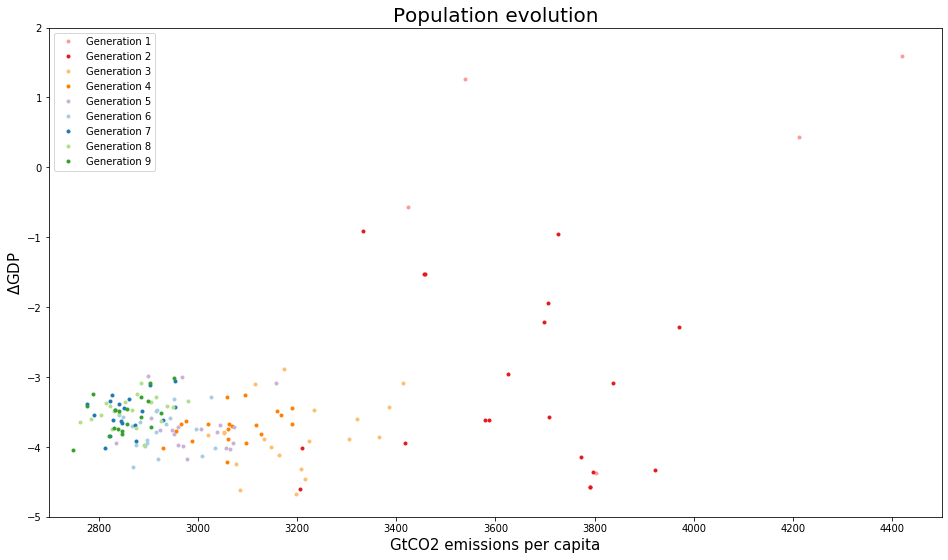

In [48]:
# Run GA optimiser
fitness_progress, lever_vals = iterate(iterations = 9, plot = True, population_size = 20, constraint = True, threshold = True,  constraint_levers = constraint_lever_names, constraint_values = constraint_lever_values,  threshold_names = threshold_names, thresholds = thresholds, output_constraint_names = output_constraint_names, output_constraints = output_constraints)##, std_devs = std_devs)

## Cost minimisation

In [53]:
temp_fitness_progress[-1] = temp_fitness_progress[-2]

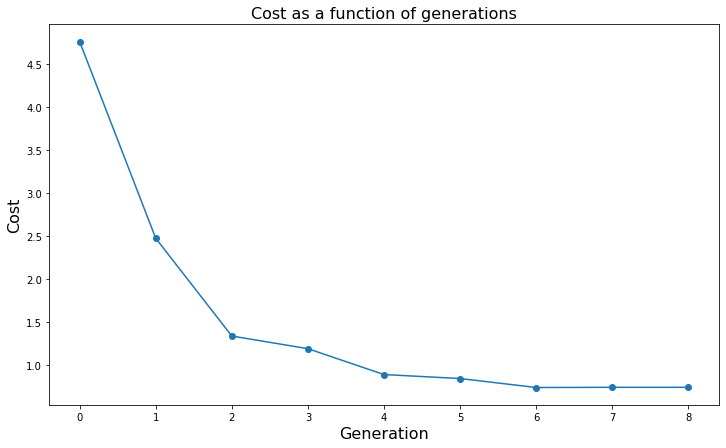

In [54]:
plt.figure(figsize = (12, 7))
plt.title("Cost as a function of generations", fontsize = 16)
plt.xlabel("Generation", fontsize = 16)
plt.ylabel("Cost", fontsize = 16)
plt.plot(temp_fitness_progress, '-o')